In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
series = np.sin((0.1*np.arange(800))**2)

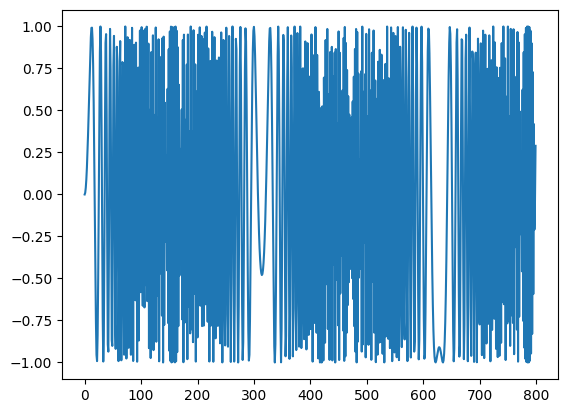

In [3]:
plt.plot(series)
plt.show()

In [4]:
#Build the data
N = len(series)
T = 10
X = []
Y = []

for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)

Y = np.array(Y).reshape(-1,1)

X.shape, Y.shape

((790, 10, 1), (790, 1))

In [5]:
#SPlit the data
N = len(X)
X_train =  torch.from_numpy(X[:N//2].astype("float32"))
X_test = torch.from_numpy(X[N//2:].astype("float32"))
Y_train = torch.from_numpy(Y[:N//2].astype("float32"))
Y_test = torch.from_numpy(Y[N//2:].astype("float32"))

X_train.shape,X_test.shape,Y_train.shape , Y_test.shape

(torch.Size([395, 10, 1]),
 torch.Size([395, 10, 1]),
 torch.Size([395, 1]),
 torch.Size([395, 1]))

In [6]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [7]:
X_train, X_test, Y_train, Y_test = X_train.to(device), X_test.to(device), Y_train.to(device), Y_test.to(device)

In [12]:
#LSTM model

class RNN(nn.Module):
  def __init__(self, hidden, inputs, outputs):
    super(RNN,self).__init__()

    self.D  = inputs
    self.M = hidden
    self.K = outputs

    self.lstm= nn.LSTM(input_size = self.D, hidden_size = self.M, batch_first = True)

    self.fc = nn.Linear(self.M,self.K)

  def forward(self,x):

    h_0 = torch.zeros(1, x.shape[0],self.M).to(device)
    c_0 = torch.zeros(1, x.shape[0],self.M).to(device)

    out, _ = self.lstm(x,(h_0,c_0))

    out = self.fc(out[:,-1,:])

    return out



In [13]:
model = RNN(5,1,1)
model.to(device)

RNN(
  (lstm): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
#optimizer

criterion = nn.MSELoss()
optimizer  = torch.optim.Adam(model.parameters(),lr=0.01)

In [15]:
#training

epochs = 500

train_loss = np.zeros(epochs)

test_loss  = np.zeros(epochs)

for i in range(epochs):

  optimizer.zero_grad()

  outputs  =  model(X_train)

  loss  = criterion(outputs, Y_train)

  loss.backward()

  optimizer.step()

  train_loss[i] = loss.item()

  o = model(X_test)

  loss_test = criterion(o,Y_test)

  test_loss[i] = loss_test.item()

  print(f"epochs -- {i+1}/{epochs} , training loss -- {loss.item()} , test loss -- {loss_test.item()}")


epochs -- 1/500 , training loss -- 0.6599942445755005 , test loss -- 0.6131654977798462
epochs -- 2/500 , training loss -- 0.6299116611480713 , test loss -- 0.5906197428703308
epochs -- 3/500 , training loss -- 0.6025338172912598 , test loss -- 0.5711472034454346
epochs -- 4/500 , training loss -- 0.5780524611473083 , test loss -- 0.5549047589302063
epochs -- 5/500 , training loss -- 0.5566366910934448 , test loss -- 0.5420364737510681
epochs -- 6/500 , training loss -- 0.5384426712989807 , test loss -- 0.5326746106147766
epochs -- 7/500 , training loss -- 0.5236189365386963 , test loss -- 0.5269224047660828
epochs -- 8/500 , training loss -- 0.5122969150543213 , test loss -- 0.5248112082481384
epochs -- 9/500 , training loss -- 0.5045603513717651 , test loss -- 0.526221752166748
epochs -- 10/500 , training loss -- 0.5003818273544312 , test loss -- 0.5307602286338806
epochs -- 11/500 , training loss -- 0.4995162785053253 , test loss -- 0.5375944375991821
epochs -- 12/500 , training los

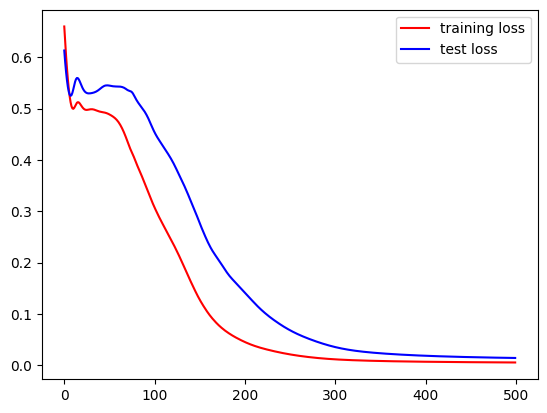

In [16]:
plt.plot(train_loss, label = "training loss", c = "r")
plt.plot(test_loss, label = "test loss", c = "b")
plt.legend()
plt.show()

In [17]:
#one step forecasting

test_predictions  = model(X_test).detach().cpu().numpy()

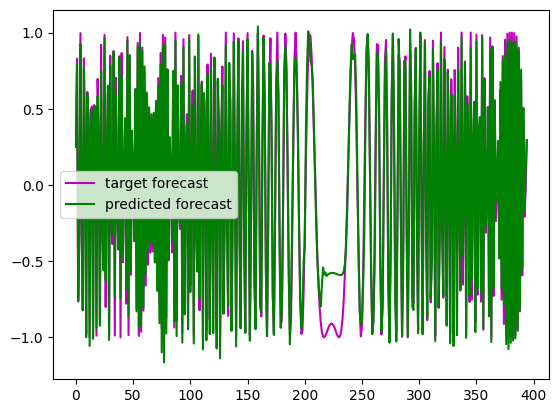

In [18]:
plt.plot(Y_test.cpu().numpy(), label = "target forecast", c = "m")
plt.plot(test_predictions, label = "predicted forecast", c = "g")
plt.legend()
plt.show()

In [19]:
#multistep forecasting

test_predictions = []

last_x = X_test[0]

while len(test_predictions) < len(X_test):

  out = model(last_x.reshape(1,T,1))

  test_predictions.append(out.item())

  x = torch.cat((last_x[1:],out))

  last_x = x

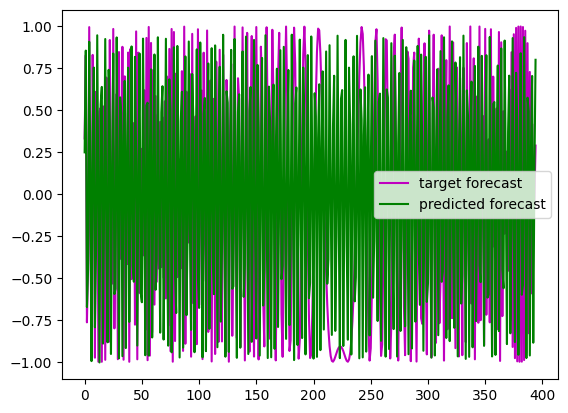

In [20]:
plt.plot(Y_test.cpu().numpy(), label = "target forecast", c = "m")
plt.plot(test_predictions, label = "predicted forecast", c = "g")
plt.legend()
plt.show()